In [1]:
#use windowing showed by jeremy used in medical imaging to see one part of the spectrum more clearly, 
#to see defects more clearly

# imports and setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai
from fastai.vision import *
from pathlib import Path
from skimage.io import imread,imshow,imsave
import warnings
from collections import defaultdict
import pandas as pd
from tqdm import tqdm_notebook  as tqdm
import os
import gc
import torch
from fastai.vision.interpret import SegmentationInterpretation
import cv2

In [3]:
def clean_instance():
    gc.collect()
    torch.cuda.empty_cache()

In [4]:
path_img = Path('train_images')
df = pd.read_csv('train.csv')
lbl_dir = Path('train_labels')
tst_dir = Path('test_images')
mixup_dir = Path('mixup_data_trn')
mixup_lbl = Path('mixup_labels')
hybrid_trn = Path('hybrid_trn')
preds_dir  = Path('valid_preds')

In [5]:
#check if the image and mask match
no = 6
img = imread(mixup_dir/(str(no)+'.png'))
pred = imread(preds_dir/(str(no)+'.png'))

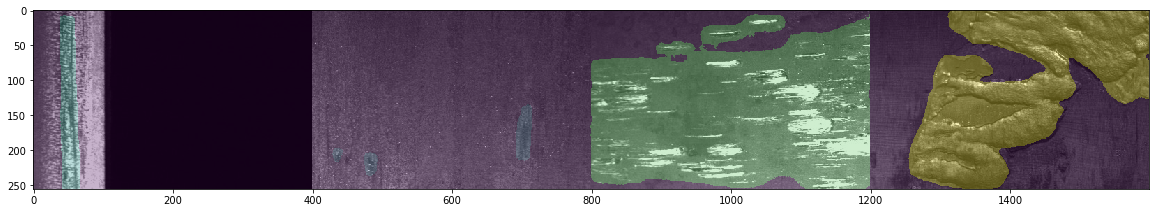

In [6]:
fig = plt.figure(figsize=(20,4))
plt.imshow(img,cmap='gray')
plt.imshow(pred,alpha=0.3)

In [7]:
#delete previous preds still in the directory
#fls = [fl for fl in preds_dir.ls() if fl.is_file()]

In [8]:
#for fl in tqdm(fls):
#    try:
#        int(fl.stem)
#    except:
#        os.remove(fl)

# generate dataset

In [7]:
fps = [fn for fn in mixup_dir.ls() if fn.is_file()]

In [8]:
len(fps)

20000

In [9]:
# check if image and pred label match
i  = 122
img = imread(fps[i],as_gray=True)
lbl = imread(preds_dir/fps[i].name)

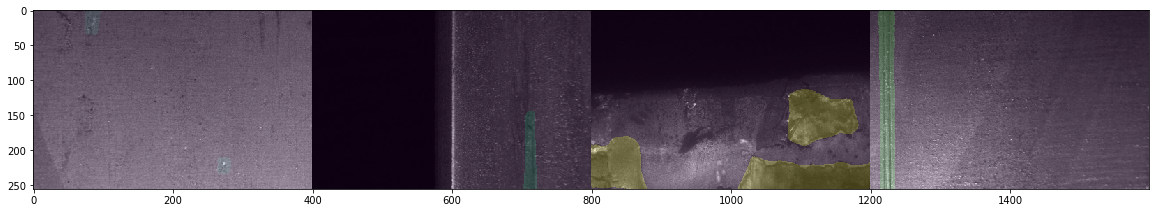

In [10]:
fig = plt.figure(figsize=(20,4))
plt.imshow(img,cmap='gray')
plt.imshow(lbl,alpha=0.2)

In [11]:
_ = np.stack((img,lbl),axis=2)

In [12]:
_.shape

(256, 1600, 2)

In [13]:
fps[i].name

'5377.png'

In [14]:
(hybrid_trn/(fps[i].stem+'.tiff')).as_posix()

'hybrid_trn/5377.tiff'

In [15]:
#cv2.imwrite((hybrid_trn/(fps[i].stem+'.tiff')).as_posix(),_)

In [16]:
def pil2arr(image,dtype):
    a = np.asarray(image)
    #if a.ndim==2 : a = np.expand_dims(a,2)
    #a = np.transpose(a, (1, 0, 2))
    #a = np.transpose(a, (2, 1, 0))
    return a.astype(dtype, copy=False)

In [17]:
class HybridSegmentationItemList(SegmentationItemList):
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
        
    #def open(self, fn, convert_mode='RGB'):
    #    "Open image in `fn`, subclass and overwrite for custom behavior."
    #    return open_image(fn, convert_mode, after_open=self.after_open)
    
    def get(self, i):
        fn = self.items[i]
        x = PIL.Image.open(fn).convert('L')
        x = pil2arr(x,np.float32)
        x /= 255
        y = PIL.Image.open(preds_dir/fn.name).convert('L')
        y = pil2arr(y,np.float32)
        y /= 4
        res = np.stack((x,y),0)
        #res = torch.from_numpy(res)
        self.sizes[i] = res.size
        #print(type(res))
        return Image(torch.from_numpy(res))

In [18]:
data = (HybridSegmentationItemList.from_folder(mixup_dir,convert_mode='L') # change dir
        #.filter_by_rand(0.1)
       .split_by_rand_pct(0.2)
       .label_from_func(lambda l:mixup_lbl/l.name,classes=['nodef','t1def','t2def','t3def','t4def'])#dir,name->stem+.png
        #.add_test(get_image_files(tst_dir))
       .transform(get_transforms(max_rotate=0,max_warp=0), tfm_y=True, size=(256,1600))
       .databunch(bs=4,num_workers=15))
       #.normalize(stats=imagenet_stats))

In [19]:
x,y = data.train_ds[1]

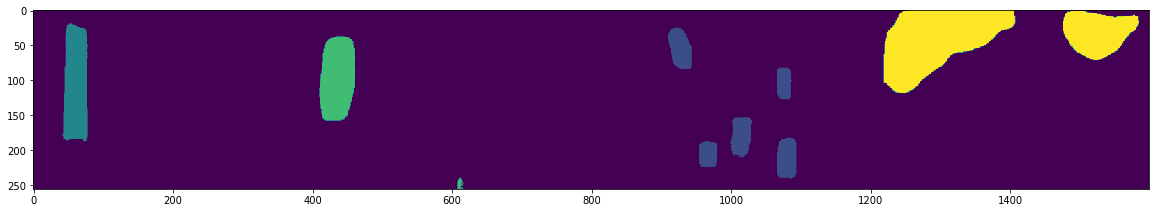

In [20]:
fig = plt.figure(figsize=(20,4))
plt.imshow(x.data[1,:,:])

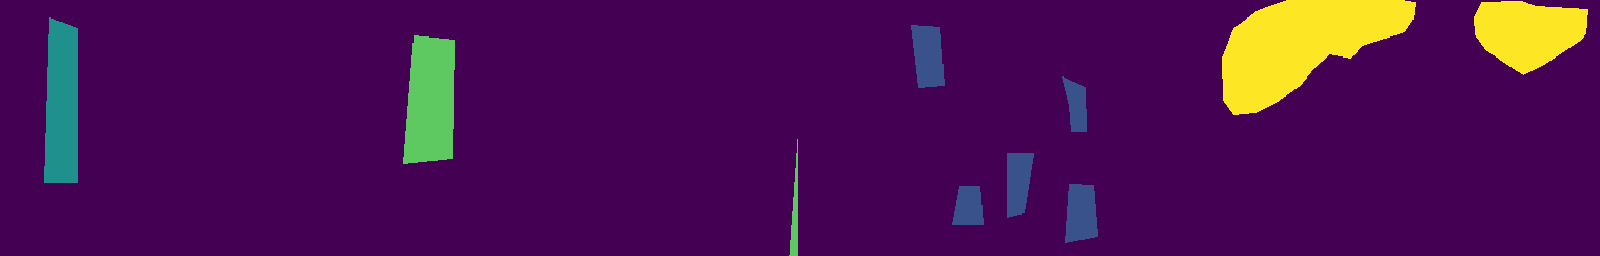

In [21]:
y

# ranger basics

In [22]:
def dice(input, targs, iou=False, eps:float=1e-8):
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    #pdb.set_trace()
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    local = []
    for cat in [1,2,3,4]:
        input_ = (input == cat)
        targs_ = (targs == cat)
        intersect = (input_ * targs_).sum(dim=1).float()
        union = (input_+targs_).sum(dim=1).float()
        if not iou: l = 2. * intersect / union
        else: l = intersect / (union-intersect+eps)
        l[union == 0.] = 1.
        local.append(l)
    for num,met in enumerate(local):
        if num == 0:
            met_img = met
        else:
            met_img += met
    met_img = met_img/4.0
    return met_img.mean()

In [23]:
from fastai.callbacks import *
from torchvision.models import *
from mxresnet import *
from functools import partial
from ranger import *

Mish activation loaded...


In [24]:
def fit_with_annealing(learn:Learner, num_epoch:int, lr:float=defaults.lr, annealing_start:float=0.7)->None:
    n = len(learn.data.train_dl)
    anneal_start = int(n*num_epoch*annealing_start)
    phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr)
    phase1 = TrainingPhase(n*num_epoch - anneal_start).schedule_hp('lr', lr, anneal=annealing_cos)
    phases = [phase0, phase1]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    learn.fit(num_epoch)

In [25]:
opt_func = partial(Ranger,  betas=(0.9,0.99), eps=1e-6)

# model

In [26]:
res = resnet18(pretrained=True)

In [27]:
res.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [28]:
c = torch.nn.Conv2d(2,64,kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [29]:
l = res.conv1.weight

In [30]:
l.data.shape

torch.Size([64, 3, 7, 7])

In [31]:
torch.sum(l.data.detach(),dim=1).shape

torch.Size([64, 7, 7])

In [32]:
summed_weights = torch.sum(l.data.detach(),dim=1)

In [33]:
summed_weights.shape

torch.Size([64, 7, 7])

In [34]:
needed_weights = torch.stack((summed_weights,summed_weights),dim=1)

In [35]:
needed_weights.shape

torch.Size([64, 2, 7, 7])

In [36]:
c.weight.data = needed_weights

In [37]:
res.conv1 = c

In [38]:
res_body = nn.Sequential(*list(res.children())[:-2])

In [39]:
size = data.train_ds[0][0].size;
size

torch.Size([256, 1600])

In [40]:
model = to_device(models.unet.DynamicUnet(res_body, n_classes=data.c, img_size=size, blur=False, blur_final=True,
          self_attention=False, y_range=None, norm_type=NormType, last_cross=True,
          bottle=False), data.device)

In [42]:
learn = Learner(data, model, metrics=dice, wd=0.01,opt_func=opt_func).to_fp16()
learn.load('tues3');

Using Ranger Optimizer...
set state called


In [97]:
learn.unfreeze()

Using Ranger Optimizer...


In [44]:
#learn = unet_learner(data, resnet18,pretrained=True,metrics=dice, wd=0.01, bottle=True,opt_func=opt_func).to_fp16()

Using Ranger Optimizer...


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


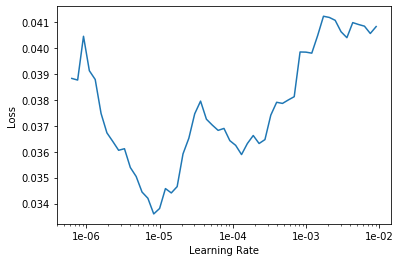

In [106]:
learn.lr_find()
learn.recorder.plot()

In [46]:
fit_with_annealing(learn, 1, 0.001)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time
0,0.040902,0.039209,0.899933,46:06


In [69]:
learn.save('tues')

In [72]:
fit_with_annealing(learn, 1, 0.0001)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time
0,0.038084,0.038177,0.900597,47:19


In [83]:
learn.save('tues1')

In [86]:
learn.unfreeze()

Using Ranger Optimizer...


In [89]:
fit_with_annealing(learn, 1, 0.0001)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time
0,0.039253,0.038005,0.900785,45:32


In [95]:
learn.save('tues2')

In [99]:
fit_with_annealing(learn, 1, 0.0006)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time
0,0.039522,0.037798,0.901202,45:45


In [105]:
learn.save('tues3')

In [196]:
a = np.arange(0,1600,1)
def iterate():
    for i in a:
        yield i

In [303]:
iterator = iterate()

In [ ]:
#0,1,6,8,9,26,

In [433]:
_ = next(iterator)
x,y = data.valid_ds[_]
_

24

In [434]:
yp = learn.predict(x)

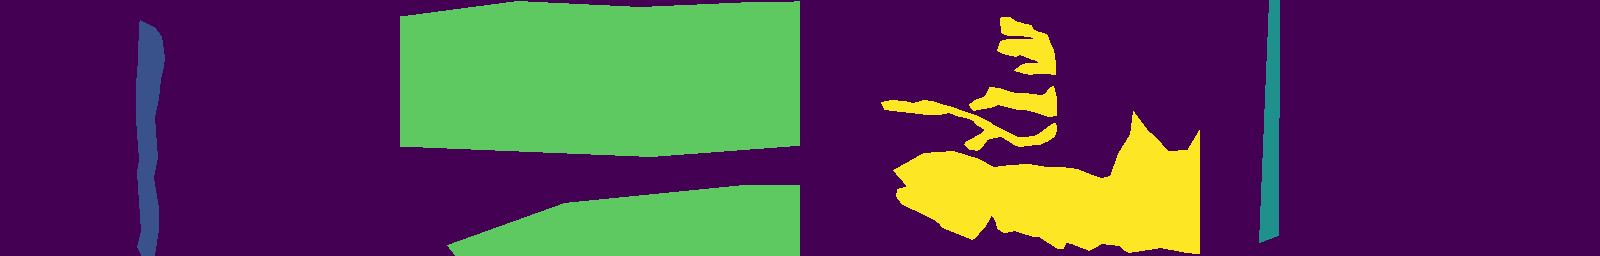

In [435]:
y

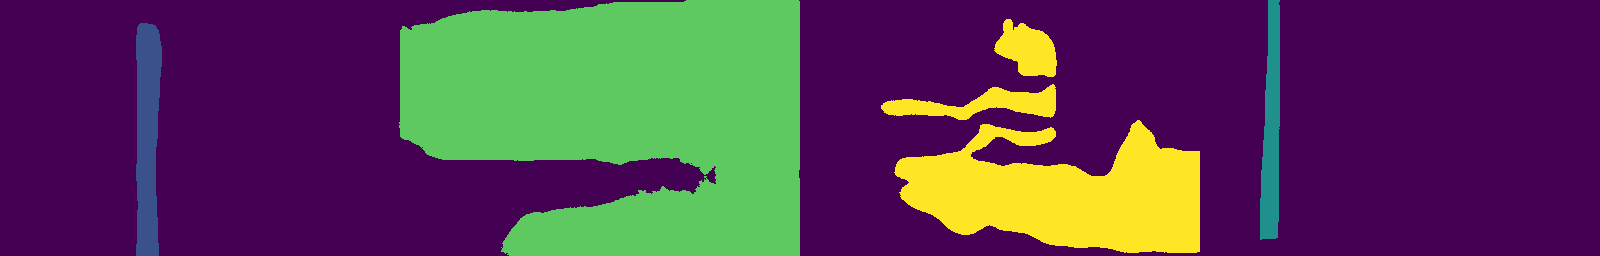

In [436]:
yp[0]

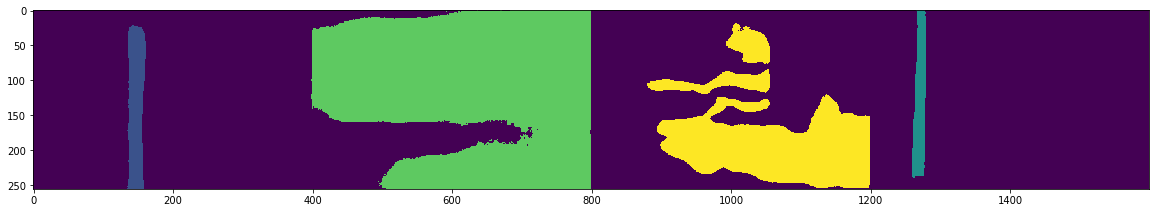

In [437]:
fig = plt.figure(figsize=(20,4))
plt.imshow(x.data[1,:,:].numpy())

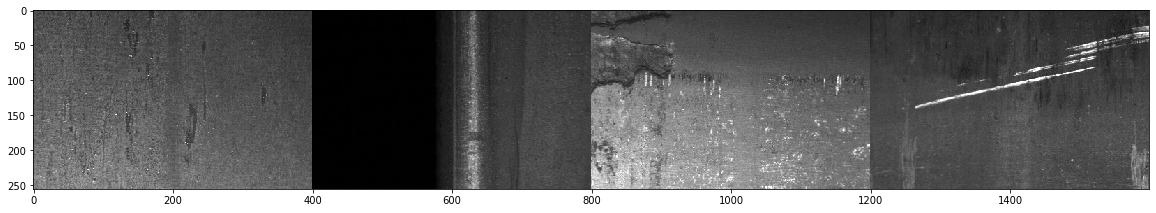

In [402]:
fig = plt.figure(figsize=(20,4))
plt.imshow(x.data[0,:,:].numpy(),cmap='gray')